In [397]:
import numpy as np
import skimage.io as skio
import skimage.util as sku

In [398]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 8)

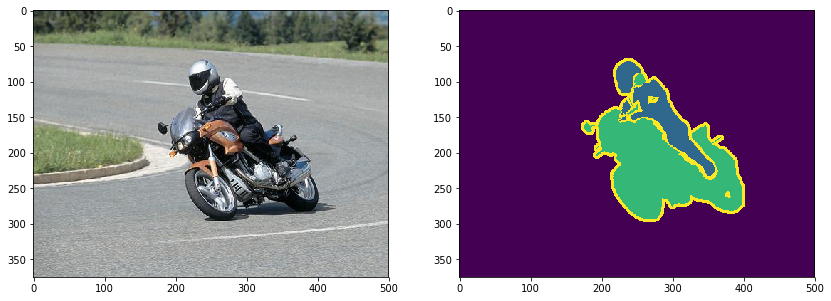

In [399]:
img = sku.img_as_float(skio.imread("moto.jpg"))

seg_orig = skio.imread("moto_seg.png")
_, true_seg = np.unique(seg_orig.reshape(-1, 3), axis=0, return_inverse=True)
true_seg = true_seg.reshape(seg_orig.shape[:2])

_, (left, right) = plt.subplots(1, 2)
right.imshow(true_seg);
left.imshow(img);

In [400]:
import skimage.segmentation as seg

In [401]:
from skimage.future import graph
import skimage.filters as skf
import skimage.color as skc

In [402]:
def hufbauer_alpha(image, labels, connectivity=2, fudge=1e-8):
    rag = graph.RAG(labels, connectivity=connectivity)

    for n in rag:
        rag.node[n].update({'labels': [n],
                            'pixel count': 0,
                            'total color': np.array([0, 0, 0],
                                                    dtype=np.double)})

    for index in np.ndindex(labels.shape):
        current = labels[index]
        rag.node[current]['pixel count'] += 1
        rag.node[current]['total color'] += image[index]

    for n in rag:
        rag.node[n]['mean color'] = (rag.node[n]['total color'] /
                                     rag.node[n]['pixel count'])
        rag.node[n]['alpha'] = np.sum(rag.node[n]['mean color'] ** 2)

    for x, y, d in rag.edges(data=True):
        #d['weight'] = 1 / (fudge + (rag.node[x]['alpha'] - rag.node[y]['alpha']) ** 2)
        d['weight'] = -((rag.node[x]['alpha'] - rag.node[y]['alpha']) ** 2.)
        #d['weight'] = np.log((rag.node[x]['alpha'] - rag.node[y]['alpha']) ** 2.)

    return rag

In [403]:
def hufbauer_beta(image, labels, connectivity=2):
    image = skc.rgb2lab(image)[:, :, [1,2]]
    rag = graph.RAG(labels, connectivity=connectivity)

    for n in rag:
        rag.node[n].update({'labels': [n],
                            'pixel count': 0,
                            'total hue': np.array([0, 0],
                                                    dtype=np.double)})

    for index in np.ndindex(labels.shape):
        current = labels[index]
        rag.node[current]['pixel count'] += 1
        rag.node[current]['total hue'] += image[index]

    for n in rag:
        rag.node[n]['mean hue'] = (rag.node[n]['total hue'] /
                                     rag.node[n]['pixel count'])

    for x, y, d in rag.edges(data=True):
        diff = 1 / (1 + (rag.node[x]['mean hue'] - rag.node[y]['mean hue']) ** 2)
        diff = np.linalg.norm(diff)
        d['weight'] = diff

    return rag

In [404]:
from sklearn.neighbors import LocalOutlierFactor as LOF

In [405]:
def normalize_graph(g):
    values = []
    for _, _, d in g.edges(data=True):
        values.append(d["weight"])
    values = np.sort(values)
    
    # outlier smoothing
    outliers = LOF().fit_predict(values[:, None])
    values =  values[outliers > 0]
    min_val, max_val = values.min(), values.max() - values.min()
    
    for _, _, d in g.edges(data=True):
        weight = d["weight"]
        
        if weight > max_val: 
            weight = max_val
        if weight < min_val:
            weight = min_val
        weight = (weight - min_val) / max_val
        
        d["weight"] = weight
    
    return g

In [406]:
sps = seg.slic(img, slic_zero=True)
rag_a = normalize_graph(hufbauer_alpha(img, sps))
rag_b = normalize_graph(hufbauer_beta(img, sps))

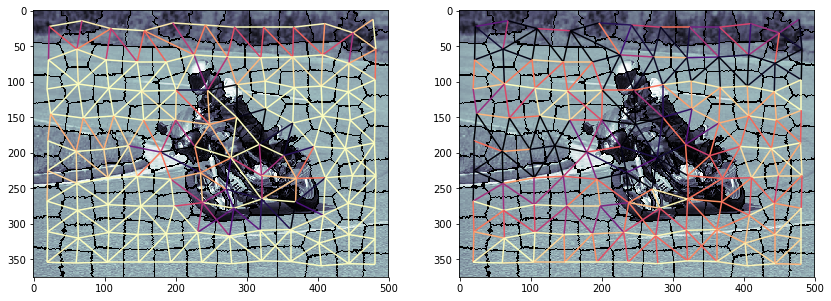

In [407]:
_, (l, r) = plt.subplots(1, 2)
graph.show_rag(sps, rag_a, img, ax=l)
graph.show_rag(sps, rag_b, img, ax=r)

In [408]:
sps = seg.slic(img, slic_zero=True)
num_sps = sps.max() + 1

rag_a = normalize_graph(hufbauer_alpha(img, sps))
rag_b = normalize_graph(hufbauer_beta(img, sps))

adj_a = nx.adjacency_matrix(rag_a).todense()
adj_b = nx.adjacency_matrix(rag_b).todense()

adj = np.c_[
    np.r_[
        adj_a, 
        np.diag(np.ones(num_sps)) * 0.1,
    ],
    np.r_[
        np.diag(np.ones(num_sps)) * 0.1,
        adj_b,
    ],
]

In [409]:
import networkx as nx
import dynSIS
import importlib
importlib.reload(dynSIS)

<module 'dynSIS' from '/Users/emory/Desktop/587/image_seg_interdep_epidemic/src/notebooks/dynSIS.py'>

In [410]:
# Run it through the simulator
proposals = dynSIS.dyn_run(nx.Graph(adj), samples=108, transmission=0.25, run_time=3, init=1)
# Extract the data
proposals = np.array([np.fromiter(prop.values(), dtype=float) for prop in proposals]).T
# Fold the two layers together
proposals = sum(np.array(np.split(proposals, 2)), 0).T

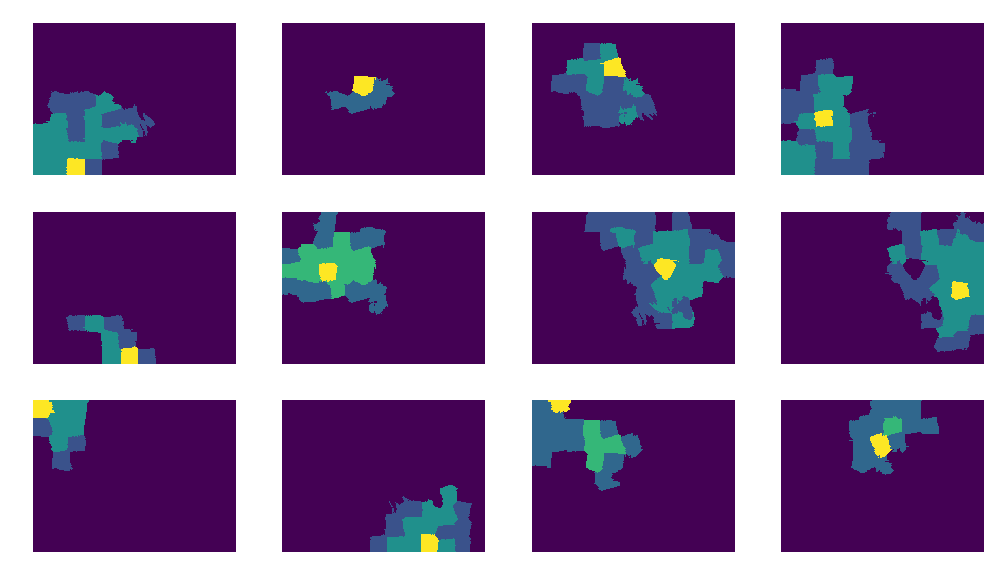

In [ ]:
_, axs = plt.subplots(3,4)
for bar, ax in zip(proposals, axs.flat):
    ax.matshow(bar[sps])
    ax.set_axis_off()
plt.tight_layout();

In [ ]:
_, axs = plt.subplots(3,4)
for bar, ax in zip(proposals, axs.flat):
    ax.matshow(bar[sps] < .05)
    ax.set_axis_off()
plt.tight_layout();

In [ ]:
def merge_proposals(proposals, sps, thresh):
    masks = (proposals[sps] < thresh).astype(int)
    
    base = np.zeros_like(masks[:,:,0])
    for mask in np.rollaxis(masks, 2):
        base = seg.join_segmentations(base, mask)
    return base

In [ ]:
segmentation = merge_proposals(proposals, sps, 0.1)
plt.matshow(segmentation)

In [ ]:
from sklearn.metrics import adjusted_rand_score

In [ ]:
adjusted_rand_score(true_seg.flat, segmentation.flat)